# MD Folding Simulation of the TRP Cage Protein with Heavy-H (Local)

This is an attempt to fold the TRP Cage protein using a MD simulation. The simulation will be run with explicit water and at 325K which *should* allow the full configuration space of the protein to be explored. The protein is initially generated using pymol by adding a single amino acid residue one at a time. This creates a linear backbone that should be ready for folding. The hydrogen atoms are increased in weight to around 4 AMU to allow the timestep in the simulation to be larger, and thus allows for faster simulation runs. This should not affect the final folded configuration.

The computationally expensive parts of this simulation will be run on Artemis (the HPC at Sydney University) and as such there is a [second related notebook](./folding_study_artemis.ipynb) that contains the commands run on Artemis.

---
To begin with we will convert our PDB file into a gromacs format. In this step we specify the water model that we will be using (-water spce) and also increase the weight of all of the hydrogen atoms to 4 (-heavyh). The -ignh ignores the specification of the hydrogen atoms in the PDB file and regenerates them, this is required if the hydrogen naming convention in the PDB file does not match what is expected by gromacs. 

In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('../../..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from helpers.GromacsHelpers import *
%matplotlib inline

In [1]:
%%bash
module load gromacs

gmx pdb2gmx -f trp_cage_linear.pdb -o trp_cage_processed.gro -ignh -heavyh -water spce -ff oplsaa 2>/dev/null


Using the Oplsaa force field in directory oplsaa.ff

Reading trp_cage_linear.pdb...
Read 153 atoms
Analyzing pdb file
Splitting chemical chains based on TER records or chain id changing.
There are 1 chains and 0 blocks of water and 20 residues with 153 atoms

  chain  #res #atoms
  1 ' '    20    153  

Reading residue database... (oplsaa)
Processing chain 1 (153 atoms, 20 residues)
Identified residue ASN2 as a starting terminus.
Identified residue SER21 as a ending terminus.
Start terminus ASN-2: NH3+
End terminus SER-21: COO-
Checking for duplicate atoms....
Generating any missing hydrogen atoms and/or adding termini.
Now there are 20 residues with 304 atoms
		--------- PLEASE NOTE ------------
You have successfully generated a topology from: trp_cage_linear.pdb.
The Oplsaa force field and the spce water model are used.
		--------- ETON ESAELP ------------


---
Next we will adjust the box size and then add the water molecules. The box chosen will be cubic as this will suit the globular folded protein structure. However when the protein is in its initial linear form, the cubic box will end up being significantly oversized. This will result in there being a large number of water molecules introduced during the solvation step which will in-turn cause the simulation to run slower than necessary.

To deal with this situation, we will initially solvate the larger box with a large number of water molecules and run the simulation for ~10 nS. After this initial run, the protein should have shifted to a more globular form. At this point we will strip out the solvent, correct the box size to a smaller box and then resolvate. The simulation will then be able to run with the lower solvent load for the remainder of the simulation.

In [2]:
%%bash
module load gromacs

gmx editconf -f trp_cage_processed.gro -o trp_cage_newbox.gro -c -d 1.0 -bt cubic 2>/dev/null
gmx solvate -cp trp_cage_newbox.gro -cs spc216.gro -o trp_cage_solv.gro -p topol.top 2>/dev/null

Read 304 atoms
Volume: 36.3039 nm^3, corresponds to roughly 16300 electrons
No velocities found
    system size :  4.702  3.644  2.119 (nm)
    diameter    :  5.546               (nm)
    center      :  2.329  1.321  0.388 (nm)
    box vectors :  4.702  3.643  2.119 (nm)
    box angles  :  90.00  90.00  90.00 (degrees)
    box volume  :  36.30               (nm^3)
    shift       :  1.444  2.452  3.385 (nm)
new center      :  3.773  3.773  3.773 (nm)
new box vectors :  7.546  7.546  7.546 (nm)
new box angles  :  90.00  90.00  90.00 (degrees)
new box volume  : 429.69               (nm^3)

         based on residue and atom names, since they could not be
         definitively assigned from the information in your input
         files. These guessed numbers might deviate from the mass
         and radius of the atom type. Please check the output
         files if necessary.

NOTE: From version 5.0 gmx solvate uses the Van der Waals radii
from the source below. This means the results may b

---
Our protein has a net charge of 1 (which can be seen in the topol.top file). This charge needs to be neutralised with a counter-ion. In this next step we replace one of the water molecules with a chlorine ion to neutralise the solution. The configuratio file required here is just the same as the energy minimisation file that we will need in the next step.

**Warning - if you run this step more than once, it will keep adding chlorine ions to the system each time!!!** 

In [3]:
%%file em.mdp
; Parameters describing what to do, when to stop and what to save
integrator  = steep     ; Algorithm (steep = steepest descent minimization)
emtol       = 1000.0    ; Stop minimization when the maximum force < 1000.0 kJ/mol/nm
emstep      = 0.01      ; Energy step size
nsteps      = 50000     ; Maximum number of (minimization) steps to perform

; Parameters describing how to find the neighbors of each atom and how to calculate the interactions
nstlist         = 1         ; Frequency to update the neighbor list and long range forces
cutoff-scheme   = Verlet
ns_type         = grid      ; Method to determine neighbor list (simple, grid)
coulombtype     = PME       ; Treatment of long range electrostatic interactions
rcoulomb        = 1.0       ; Short-range electrostatic cut-off
rvdw            = 1.0       ; Short-range Van der Waals cut-off
pbc             = xyz       ; Periodic Boundary Conditions (yes/no)

Overwriting em.mdp


In [4]:
%%bash
module load gromacs

gmx grompp -f em.mdp -c trp_cage_solv.gro -p topol.top -o ions.tpr 2>/dev/null
gmx genion -s ions.tpr -o trp_cage_solv_ions.gro -p topol.top -pname NA -nname CL -nn 1 <<< $'13\n' 2>/dev/null

Analysing residue names:
There are:    20    Protein residues
There are: 13482      Water residues
Analysing Protein...
Calculating fourier grid dimensions for X Y Z
Using a fourier grid of 64x64x64, spacing 0.118 0.118 0.118
This run will generate roughly 3 Mb of data
Will try to add 0 NA ions and 1 CL ions.
Select a continuous group of solvent molecules
Selected 13: 'SOL'

Processing topology
Replacing 1 solute molecules in topology file (topol.top)  by 0 NA and 1 CL ions.


---
The next step is to relax the system (protein and solvent). This is done by using a steepest descent minimisation. This step helps to ensure that the system will not blow up when the MD runs start.

In [5]:
%%bash
module load gromacs

gmx grompp -f em.mdp -c trp_cage_solv_ions.gro -p topol.top -o em.tpr 2> /dev/null
gmx mdrun -v -deffnm em 2> /dev/null

Analysing residue names:
There are:    20    Protein residues
There are: 13481      Water residues
There are:     1        Ion residues
Analysing Protein...
Analysing residues not classified as Protein/DNA/RNA/Water and splitting into groups...
Calculating fourier grid dimensions for X Y Z
Using a fourier grid of 64x64x64, spacing 0.118 0.118 0.118
This run will generate roughly 3 Mb of data


In [7]:
%%bash
module load gromacs

gmx energy -f em.edr -o em.xvg <<< $'10\n' 2>/dev/null


Statistics over 816 steps [ 0.0000 through 815.0000 ps ], 1 data sets
All statistics are over 646 points (frames)

Energy                      Average   Err.Est.       RMSD  Tot-Drift
-------------------------------------------------------------------------------
Potential                   -693797       9800    22885.5   -64910.2  (kJ/mol)


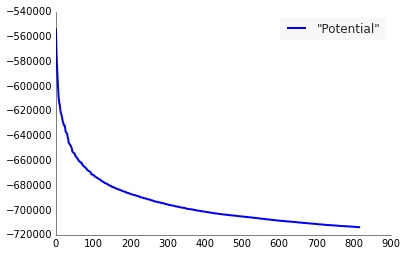

In [2]:
plotFigure("em.xvg")

In [3]:
%%bash
module load gromacs

gmx editconf -f em.gro -o em.pdb 2>/dev/null

Read 40748 atoms
Volume: 429.687 nm^3, corresponds to roughly 193300 electrons
No velocities found


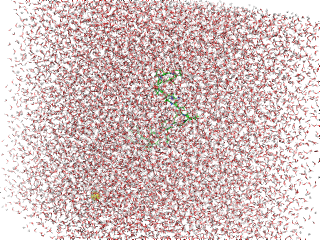

In [4]:
pymolPlotStructure("em.pdb")

---
Now that the protein is solvates, neutralized and relaxed we need to bring the simulation up to temperature and pressure. This is done in two stages:
1. Use a thermostat to equilibrate the water temperature to 325K,
2. Equilibrate the pressure to 1 bar.

Both of these steps are performed with position restraints on the protein to prevent it from moving during equilibration.

In [5]:
%%file nvt.mdp
define      = -DPOSRES  ; position restrain the protein
; Run parameters
integrator  = md        ; leap-frog integrator
nsteps      = 50000     ; 2 * 50000 = 100 ps
dt          = 0.002     ; 2 fs

; Output control
nstxout     = 500       ; save coordinates every 1.0 ps
nstvout     = 500       ; save velocities every 1.0 ps
nstenergy   = 500       ; save energies every 1.0 ps
nstlog      = 500       ; update log file every 1.0 ps

; Bond parameters
continuation            = no        ; first dynamics run
constraint_algorithm    = lincs     ; holonomic constraints 
constraints             = all-bonds ; all bonds (even heavy atom-H bonds) constrained
lincs_iter              = 1         ; accuracy of LINCS
lincs_order             = 4         ; also related to accuracy

; Neighborsearching
cutoff-scheme   = Verlet
ns_type         = grid      ; search neighboring grid cells
nstlist         = 10        ; 20 fs, largely irrelevant with Verlet
rcoulomb        = 1.0       ; short-range electrostatic cutoff (in nm)
rvdw            = 1.0       ; short-range van der Waals cutoff (in nm)

; Electrostatics
coulombtype     = PME   ; Particle Mesh Ewald for long-range electrostatics
pme_order       = 4     ; cubic interpolation
fourierspacing  = 0.16  ; grid spacing for FFT

; Temperature coupling is on
tcoupl      = V-rescale             ; modified Berendsen thermostat
tc-grps     = Protein Non-Protein   ; two coupling groups - more accurate
tau_t       = 0.1  0.1              ; time constant, in ps
ref_t       = 325  325              ; reference temperature, one for each group, in K

; Pressure coupling is off
pcoupl      = no        ; no pressure coupling in NVT

; Periodic boundary conditions
pbc         = xyz       ; 3-D PBC

; Dispersion correction
DispCorr    = EnerPres  ; account for cut-off vdW scheme

; Velocity generation
gen_vel     = yes       ; assign velocities from Maxwell distribution
gen_temp    = 325       ; temperature for Maxwell distribution
gen_seed    = -1        ; generate a random seed

Writing nvt.mdp


In [7]:
%%bash
module load gromacs

gmx grompp -f nvt.mdp -c em.gro -p topol.top -o nvt.tpr 2>/dev/null

turning all bonds into constraints...
turning all bonds into constraints...
turning all bonds into constraints...
Analysing residue names:
There are:    20    Protein residues
There are: 13481      Water residues
There are:     1        Ion residues
Analysing Protein...
Analysing residues not classified as Protein/DNA/RNA/Water and splitting into groups...
Determining Verlet buffer for a tolerance of 0.005 kJ/mol/ps at 325 K
Calculated rlist for 1x1 atom pair-list as 1.013 nm, buffer size 0.013 nm
Set rlist, assuming 4x4 atom pair-list, to 1.000 nm, buffer size 0.000 nm
Note that mdrun will redetermine rlist based on the actual pair-list setup
Calculating fourier grid dimensions for X Y Z
Using a fourier grid of 48x48x48, spacing 0.157 0.157 0.157
This run will generate roughly 98 Mb of data


In [9]:
%%bash
scp nvt.tpr psol3692@hpc.sydney.edu.au:/project/MDPF/trp_cage/folding_study/

In [10]:
%%bash
scp psol3692@hpc.sydney.edu.au:/project/MDPF/trp_cage/folding_study/nvt.gro .
scp psol3692@hpc.sydney.edu.au:/project/MDPF/trp_cage/folding_study/nvt.cpt .
scp psol3692@hpc.sydney.edu.au:/project/MDPF/trp_cage/folding_study/nvt.edr .

In [11]:
%%bash
module load gromacs

gmx energy -f nvt.edr -o nvt_temp.xvg <<< $'15\n' 2>/dev/null


Statistics over 50001 steps [ 0.0000 through 100.0000 ps ], 1 data sets
All statistics are over 501 points

Energy                      Average   Err.Est.       RMSD  Tot-Drift
-------------------------------------------------------------------------------
Temperature                 324.814       0.33    3.52721    2.18822  (K)


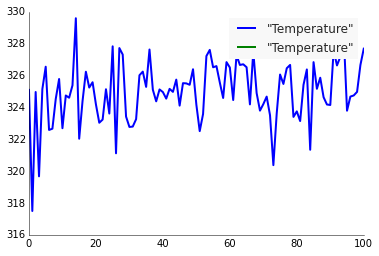

In [5]:
plotFigure("nvt_temp.xvg")

In [13]:
%%file npt.mdp
define      = -DPOSRES  ; position restrain the protein
; Run parameters
integrator  = md        ; leap-frog integrator
nsteps      = 50000     ; 2 * 50000 = 100 ps
dt          = 0.002     ; 2 fs

; Output control
nstxout     = 500       ; save coordinates every 1.0 ps
nstvout     = 500       ; save velocities every 1.0 ps
nstenergy   = 500       ; save energies every 1.0 ps
nstlog      = 500       ; update log file every 1.0 ps

; Bond parameters
continuation            = yes       ; restarting acter NVT
constraint_algorithm    = lincs     ; holonomic constraints 
constraints             = all-bonds ; all bonds (even heavy atom-H bonds) constrained
lincs_iter              = 1         ; accuracy of LINCS
lincs_order             = 4         ; also related to accuracy

; Neighborsearching
cutoff-scheme   = Verlet
ns_type         = grid      ; search neighboring grid cells
nstlist         = 10        ; 20 fs, largely irrelevant with Verlet
rcoulomb        = 1.0       ; short-range electrostatic cutoff (in nm)
rvdw            = 1.0       ; short-range van der Waals cutoff (in nm)

; Electrostatics
coulombtype     = PME   ; Particle Mesh Ewald for long-range electrostatics
pme_order       = 4     ; cubic interpolation
fourierspacing  = 0.16  ; grid spacing for FFT

; Temperature coupling is on
tcoupl      = V-rescale             ; modified Berendsen thermostat
tc-grps     = Protein Non-Protein   ; two coupling groups - more accurate
tau_t       = 0.1  0.1              ; time constant, in ps
ref_t       = 325  325              ; reference temperature, one for each group, in K

; Pressure coupling is on
pcoupl              = Parrinello-Rahman     ; Pressure coupling on in NPT
pcoupltype          = isotropic             ; uniform scaling of box vectors
tau_p               = 2.0                   ; time constant, in ps
ref_p               = 1.0                   ; reference pressure, in bar
compressibility     = 4.5e-5                ; isothermal compressibility of water, bar^-1
refcoord_scaling    = com

; Periodic boundary conditions
pbc         = xyz       ; 3-D PBC

; Dispersion correction
DispCorr    = EnerPres  ; account for cut-off vdW scheme

; Velocity generation
gen_vel     = no       ; Velocity generation is off

Writing npt.mdp


In [15]:
%%bash
module load gromacs

gmx grompp -f npt.mdp -c nvt.gro -t nvt.cpt -p topol.top -o npt.tpr 2>/dev/null
scp npt.tpr psol3692@hpc.sydney.edu.au:/project/MDPF/trp_cage/folding_study/

turning all bonds into constraints...
turning all bonds into constraints...
turning all bonds into constraints...
Analysing residue names:
There are:    20    Protein residues
There are: 13481      Water residues
There are:     1        Ion residues
Analysing Protein...
Analysing residues not classified as Protein/DNA/RNA/Water and splitting into groups...
Determining Verlet buffer for a tolerance of 0.005 kJ/mol/ps at 325 K
Calculated rlist for 1x1 atom pair-list as 1.013 nm, buffer size 0.013 nm
Set rlist, assuming 4x4 atom pair-list, to 1.000 nm, buffer size 0.000 nm
Note that mdrun will redetermine rlist based on the actual pair-list setup
Calculating fourier grid dimensions for X Y Z
Using a fourier grid of 48x48x48, spacing 0.157 0.157 0.157
This run will generate roughly 98 Mb of data


In [25]:
%%bash
scp psol3692@hpc.sydney.edu.au:/project/MDPF/trp_cage/folding_study/npt.{gro,cpt,edr} .

In [27]:
%%bash
module load gromacs

gmx energy -f npt.edr -o npt_pres.xvg <<< $'16\n' 2>/dev/null
gmx energy -f npt.edr -o npt_dens.xvg <<< $'22\n' 2>/dev/null


Statistics over 50001 steps [ 0.0000 through 100.0000 ps ], 1 data sets
All statistics are over 501 points

Energy                      Average   Err.Est.       RMSD  Tot-Drift
-------------------------------------------------------------------------------
Pressure                   0.423692        4.8    130.273    9.52515  (bar)

Statistics over 50001 steps [ 0.0000 through 100.0000 ps ], 1 data sets
All statistics are over 501 points

Energy                      Average   Err.Est.       RMSD  Tot-Drift
-------------------------------------------------------------------------------
Density                     985.377       0.11    3.21938   0.925512  (kg/m^3)


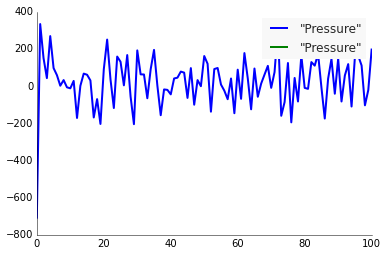

In [3]:
plotFigure("npt_pres.xvg")

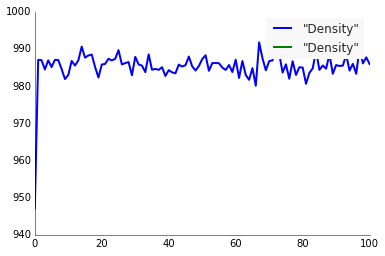

In [4]:
plotFigure("npt_dens.xvg")

The temperature and pressure seem to have stabalised as expected, however the density is showing around 985, whereas 1000 is what would have been expected. I am not sure if this will cause an issue or not, but we will press on and see what happens...

---
Now it is time for the MD runs. We want to run for around 10uS to give the protein plenty of time to fold. We will do this in 10 seperate 1uS runs however to prevent the data files from growing too large. Given we want to run one after another we will generate the npt files over on the hpc server rather than here, so that we can generate them in the script one by one.

To start with we will run the simulation for 100nS to get a feel for the run time. If it is going to run for too long, we can shrink the box down and remove some of the water. This is the first simulation run at the larger timestep as well.

Note: Initial attempts to run the md job with a larger step size (than 2 fS) keeps resulting in the job crashing. So I am currently running a 100nS (1 day) job with a 2 fS step size and then I will try and increase the step size again, or reduce the box size. 

In [37]:
!scp topol.top psol3692@hpc.sydney.edu.au:/project/MDPF/trp_cage/folding_study/

topol.top                                     100%   90KB  90.5KB/s   00:00    


In [6]:
!scp psol3692@hpc.sydney.edu.au:/project/MDPF/trp_cage/folding_study/md_1_0.tpr .

md_1_0.tpr                                    100% 1211KB 403.6KB/s   00:03    


In [1]:
!scp psol3692@hpc.sydney.edu.au:/project/MDPF/trp_cage/folding_study/md_1_0.{gro,cpt,xtc,log,edr,tpr} .

scp: /project/MDPF/trp_cage/folding_study/md_1_0.gro: No such file or directory
md_1_0.cpt                                    100%  957KB 319.0KB/s   00:03    
md_1_0.xtc                                    100% 1168MB   2.0MB/s   09:59    
md_1_0.log                                    100% 5045KB   1.2MB/s   00:04    


In [3]:
%%bash
module load gromacs

gmx trjconv -f md_1_0.cpt -s md_1_0.tpr -pbc mol -center true -o md_1_0.pdb <<< $'1\n1\n' 

Select group for centering
Selected 1: 'Protein'
Select group for output
Selected 1: 'Protein'


                     :-) GROMACS - gmx trjconv, 2016.2 (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov  Herman J.C. Berendsen    Par Bjelkmar   
 Aldert van Buuren   Rudi van Drunen     Anton Feenstra    Gerrit Groenhof  
 Christoph Junghans   Anca Hamuraru    Vincent Hindriksen Dimitrios Karkoulis
    Peter Kasson        Jiri Kraus      Carsten Kutzner      Per Larsson    
  Justin A. Lemkul   Magnus Lundborg   Pieter Meulenhoff    Erik Marklund   
   Teemu Murtola       Szilard Pall       Sander Pronk      Roland Schulz   
  Alexey Shvetsov     Michael Shirts     Alfons Sijbers     Peter Tieleman  
  Teemu Virolainen  Christian Wennberg    Maarten Wolf   
                           and the project leaders:
        Mark Abraham, Berk Hess, Erik Lindahl, and David van der Spoel

Copyright (c) 1991-2000, University of Groningen, The Netherlands.
Copyright (c) 2001-2015, The GROMACS development team at
Uppsala University, Stockholm University

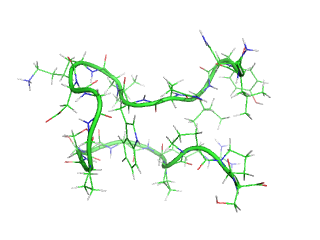

In [6]:
pymolPlotStructure("md_1_0.pdb")

In [2]:
%%bash
module load gromacs

gmx energy -f md_1_0.edr -o md_1_0_pot.xvg <<< $'10\n' 2> /dev/null


Statistics over 41545001 steps [ 0.0000 through 83090.0000 ps ], 1 data sets
All statistics are over 415451 points

Energy                      Average   Err.Est.       RMSD  Tot-Drift
-------------------------------------------------------------------------------
Potential                   -613147        5.6    862.406    12.9455  (kJ/mol)


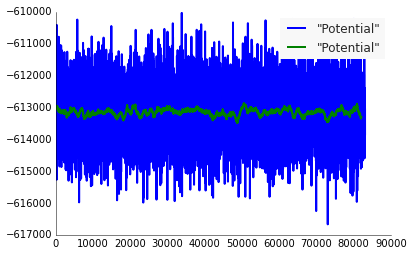

In [2]:
plotFigure("md_1_0_pot.xvg")